# Import Modules

In [0]:
import os
import time
import datetime
import string
import random
import math
import json
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
tf.reset_default_graph()
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

**List the devices available to tensorflow**

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17924708732016017838, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11288962663
 locality {
   bus_id: 1
 }
 incarnation: 16665210532787904486
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

**Make the result reproducible by setting the seed of numpy and tensorflow**

In [3]:
# np_rand_seed = random.randint(0,100)
# tf_rand_seed = random.randint(0,100)
np_rand_seed = 26
tf_rand_seed = 21
np.random.seed(np_rand_seed)
tf.set_random_seed(tf_rand_seed)
print("numpy random seed: ",np_rand_seed)
print("tensorflow random seed: ", tf_rand_seed)

numpy random seed:  26
tensorflow random seed:  21


# Load the image and mask data

## Authenticate and load zipped data to kernel

**Authentication via google auth**

In [0]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

**Upload a file from google cloud where file ids are stored as a json**

In [5]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

file_id_data= json.loads(uploaded['file_id.json'])

Saving file_id.json to file_id (3).json
User uploaded file "file_id.json" with length 222 bytes


**Download files to the kernel**

In [0]:
downloaded1 = drive.CreateFile({'id':file_id_data["stage1_train"]}) 
downloaded1.GetContentFile('stage1_train.zip')  
downloaded2 = drive.CreateFile({'id':file_id_data["stage1_test"]}) 
downloaded2.GetContentFile('stage1_test.zip')
downloaded3 = drive.CreateFile({'id':file_id_data["stage1_train_labels"]}) 
downloaded3.GetContentFile('stage1_train_labels.csv')

**Load the train labels**

In [0]:
train_labels = pd.read_csv("stage1_train_labels.csv")

In [8]:
train_labels.head(10)

,ImageId,EncodedPixels
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,6908 1 7161 8 7417 8 7672 9 7928 9 8184 9 8440...
1,00071198d059ba7f5914a526d124d28e6d010c92466da2...,36269 7 36523 11 36778 13 37033 15 37288 17 37...
2,00071198d059ba7f5914a526d124d28e6d010c92466da2...,19919 6 20174 8 20429 10 20685 11 20941 12 211...
3,00071198d059ba7f5914a526d124d28e6d010c92466da2...,18671 6 18926 8 19181 9 19436 10 19691 11 1994...
4,00071198d059ba7f5914a526d124d28e6d010c92466da2...,40158 3 40413 5 40669 5 40925 5 41182 3
5,00071198d059ba7f5914a526d124d28e6d010c92466da2...,58535 6 58791 10 59047 12 59303 16 59553 2 595...
6,00071198d059ba7f5914a526d124d28e6d010c92466da2...,31989 7 32244 12 32499 14 32754 15 33009 16 33...
7,00071198d059ba7f5914a526d124d28e6d010c92466da2...,11966 4 12220 9 12473 14 12729 15 12984 16 132...
8,00071198d059ba7f5914a526d124d28e6d010c92466da2...,58148 3 58403 5 58657 10 58912 13 59167 15 594...
9,00071198d059ba7f5914a526d124d28e6d010c92466da2...,14825 3 15080 5 15336 5 15592 5 15849 3


## Making directories and unzipping train and test data to repective directories

**Make directories for train and test images**

In [9]:
!if [ ! -d "/stage1_train" ]; then mkdir stage1_train; fi

mkdir: cannot create directory ‘stage1_train’: File exists


In [10]:
!if [ ! -d "/stage1_test" ]; then mkdir stage1_test; fi

mkdir: cannot create directory ‘stage1_test’: File exists


**Load the train and test data into designated directories**

In [11]:
!if [ "$(ls -A stage1_train)" ]; then echo "Files are already there"; else unzip stage1_train.zip -d stage1_train; fi

Files are already there


In [12]:
!if [ "$(ls -A stage1_test)" ]; then echo "Files are already there"; else unzip stage1_test.zip -d stage1_test; fi

Files are already there


# Visualize sample medical images and masks

**Image dimensions for input placeholder**

In [0]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

**Load train and test ids**

In [0]:
TRAIN_PATH = './stage1_train/'
TEST_PATH = './stage1_test/'

In [0]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
train_ids = np.array(train_ids)
test_ids = next(os.walk(TEST_PATH))[1]
test_ids = np.array(test_ids)

**Size of train and test sets**

In [16]:
print("size of train set:",len(train_ids))

size of train set: 670


In [17]:
print("size of test set:",len(test_ids))

size of test set: 65


**A function for generating batch of images, masks and their corresponding shapes**

In [0]:
def generate_batch(indices, test_set = False):
  
    
    # extract the id based of train/test set
    if test_set is False:
        batch_ids = train_ids[indices]
    else:
        batch_ids = test_ids[indices]
        
    # initialize numpy array to hold image and mask 
    X = np.zeros((len(batch_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
    Y = np.zeros((len(batch_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
    # shapes of the images
    shapes = np.zeros((len(batch_ids), 2))
  
    # iterate through each image
    for n, id_ in enumerate(batch_ids):
      
        # construct path for the image
        if test_set is False:
            path = TRAIN_PATH + id_
        else:
            path = TEST_PATH + id_
          
        # load image and shape
        img = imread(path + '/images/' + id_ + '.png')/255.0
        shape = img.shape[:2]
        shapes[n] = shape
        
        # extract the first 3 channels only
        img = img[:,:,:IMG_CHANNELS]
        # resize the image so that all images are of same shape
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X[n] = img

        # if it is a trains set then extract the masks as well
        if test_set is False:
          
            # initilize numpy array for the mask
            mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
            
            # iterate through each mask and carry our a pixel wise max operation
            for mask_file in next(os.walk(path + '/masks/'))[2]:
                mask_ = imread(path + '/masks/' + mask_file)/255.0
#                 mask_ = imread(path + '/masks/' + mask_file)
                mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
                mask = np.maximum(mask, mask_)
            Y[n] = mask
    
    
    if test_set is False:
        return X, Y, shapes
    else:
        return X, shapes

**Generate a batch**

In [0]:
indices = np.array([1,2,4,5,6,7,8,9,10])
X, Y, shapes = generate_batch(indices)

**Squeeze the mask data**

In [0]:
Y_squeezed = np.squeeze(Y)

In [21]:
print(X.shape)
print(Y.shape)
print(Y_squeezed.shape)
print(shapes.shape)

(9, 128, 128, 3)
(9, 128, 128, 1)
(9, 128, 128)
(9, 2)


**Display the sample image and corresponding mask**

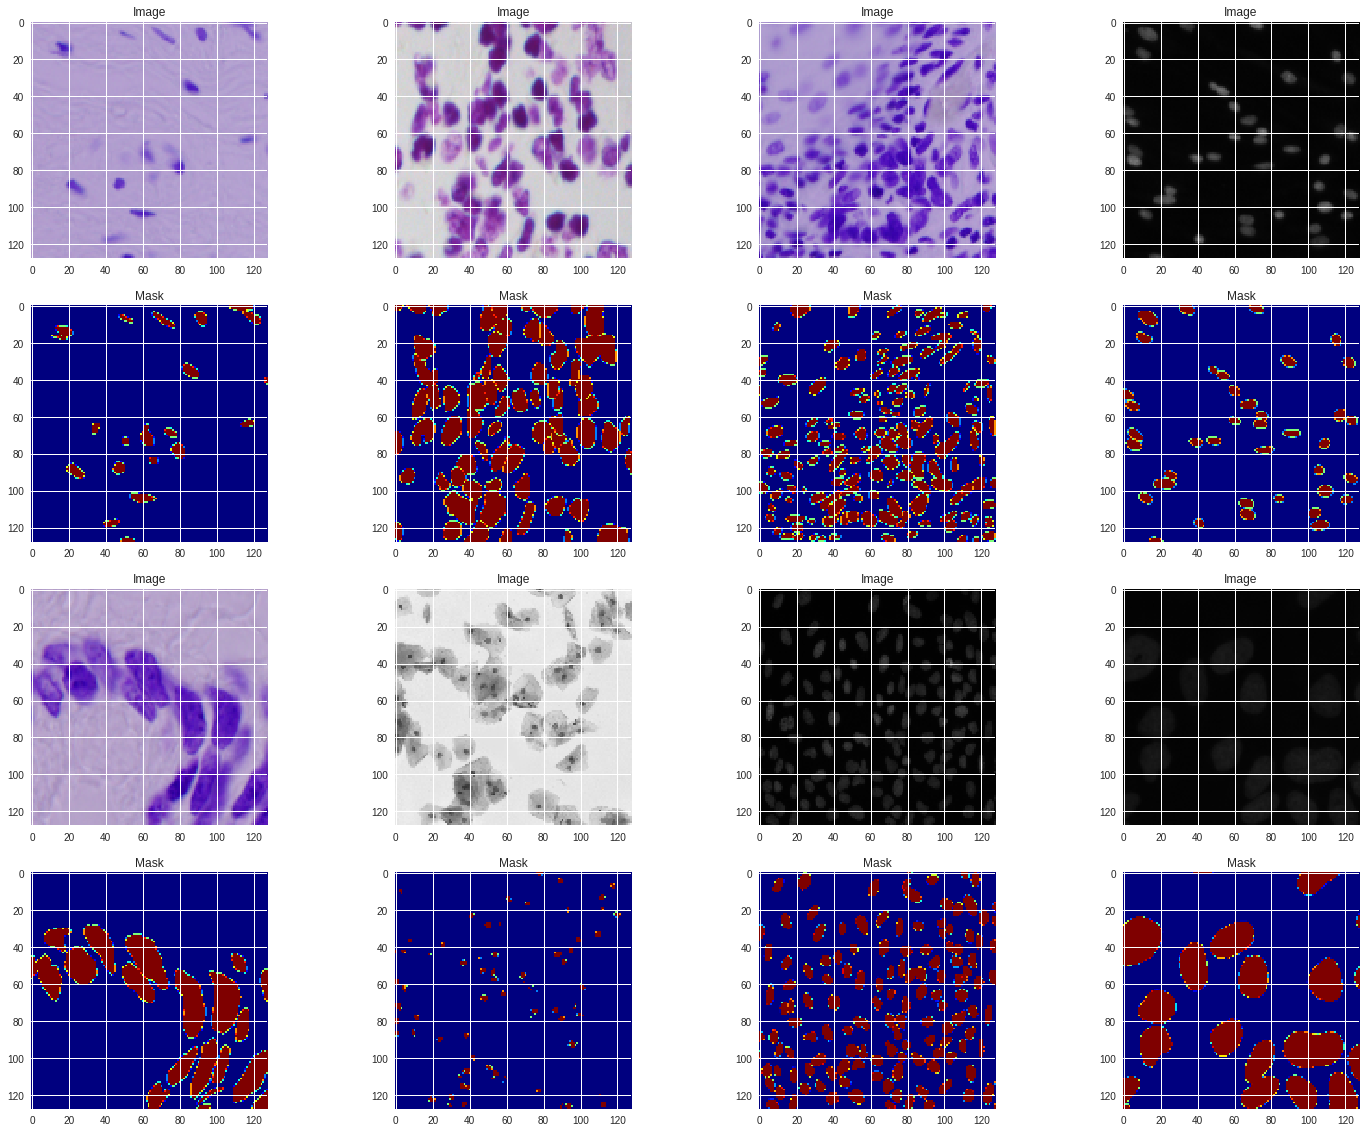

In [22]:
matplotlib.rcParams['figure.figsize'] = (25.0, 20.0)
plt.subplot(4,4,1)
plt.title("Image")
plt.imshow(X[0], cmap='jet')
plt.subplot(4,4,1+4)
plt.title("Mask")
plt.imshow(Y_squeezed[0], cmap='jet')
plt.subplot(4,4,2)
plt.title("Image")
plt.imshow(X[1], cmap='jet')
plt.subplot(4,4,2+4)
plt.title("Mask")
plt.imshow(Y_squeezed[1], cmap='jet')
plt.subplot(4,4,3)
plt.title("Image")
plt.imshow(X[2], cmap='jet')
plt.subplot(4,4,3+4)
plt.title("Mask")
plt.imshow(Y_squeezed[2], cmap='jet')
plt.subplot(4,4,4)
plt.title("Image")
plt.imshow(X[3], cmap='jet')
plt.subplot(4,4,4+4)
plt.title("Mask")
plt.imshow(Y_squeezed[3], cmap='jet')
plt.subplot(4,4,9)
plt.title("Image")
plt.imshow(X[4], cmap='jet')
plt.subplot(4,4,1+12)
plt.title("Mask")
plt.imshow(Y_squeezed[4], cmap='jet')
plt.subplot(4,4,10)
plt.title("Image")
plt.imshow(X[5], cmap='jet')
plt.subplot(4,4,2+12)
plt.title("Mask")
plt.imshow(Y_squeezed[5], cmap='jet')
plt.subplot(4,4,11)
plt.title("Image")
plt.imshow(X[6], cmap='jet')
plt.subplot(4,4,3+12)
plt.title("Mask")
plt.imshow(Y_squeezed[6], cmap='jet')
plt.subplot(4,4,12)
plt.title("Image")
plt.imshow(X[7], cmap='jet')
plt.subplot(4,4,4+12)
plt.title("Mask")
plt.imshow(Y_squeezed[7], cmap='jet')
plt.show()

# Create functions for encoding predicted mask as defined in the competition

**A function to encode flattened mask**

In [0]:
def encode_pixels(pixels, stepsize = 1): 
  
    '''A function to encode flattened mask'''
    
    consecutive_series = np.split(pixels, np.where(np.diff(pixels) != stepsize)[0]+1)
    
    encoded_series = []
    
    for series in consecutive_series:
        
        if len(series) > 0:
          first_elem = str(series[0])
          second_elem = str(len(series))
          encoded_series.append(first_elem)
          encoded_series.append(second_elem) 
          
    return " ".join(encoded_series)

**A function to encode a single maks**

In [0]:
def encode_single_mask(mask):
  
    '''A function to encode a single maks'''
  
    flattened_mask = mask.flatten(order = 'F')
    non_zero_elems = np.where(flattened_mask == 1)[0] + 1
#     non_zero_elems = np.where(flattened_mask == 0)[0] + 1
    
    encoded_pixels = encode_pixels(non_zero_elems, stepsize = 1)
    
    return encoded_pixels

**A function to encode a batch of masks**

In [0]:
def encode_masks(masks, shapes, threshold = 0.5):
  
    '''A function to encode a batch of masks'''
  
    encoded_labels = []
  
    mask_squeezed = np.squeeze(masks)
    
    for n in range(masks.shape[0]):
      
        mask = masks[n]
        
        mask = (mask - mask.min())/(mask.max() - mask.min())
        
        mask_resized = resize(mask, (shapes[n][0], shapes[n][1]), mode='constant')
        
        mask_binirized = np.where(mask_resized>threshold, 1, 0)
        
        encoded_labels.append(encode_single_mask(mask_binirized))
        
    return encoded_labels 

**Test the encode_masks function using the generated samples**

In [0]:
encoded_masks = encode_masks(Y, shapes)

In [27]:
encoded_masks[0]

'7457 2 7713 3 7969 3 8225 3 8473 2 8481 3 8728 4 8737 3 8984 5 8993 4 9239 7 9249 4 9495 14 9752 14 10008 14 10264 15 10520 15 10776 15 11032 15 11288 15 11544 15 11800 15 12056 15 12312 13 12464 4 12569 11 12719 6 12825 10 12975 6 13081 10 13230 8 13338 9 13485 10 13595 7 13741 11 13852 5 13997 11 14252 13 14508 13 14765 12 15021 13 15277 14 15534 13 15791 13 16047 13 16304 12 16561 11 16817 12 17074 11 17331 10 17588 9 17845 8 18101 6 18358 4 21124 6 21378 10 21633 11 21889 11 22145 11 22401 10 22657 10 22913 10 23169 6 23425 5 25324 3 25579 5 25835 5 26090 7 26346 7 26602 7 26858 7 27113 8 27369 8 27625 8 27881 8 28137 8 28393 7 28593 3 28649 7 28848 5 28905 7 29102 8 29160 8 29357 10 29416 8 29611 12 29673 6 29866 14 29929 6 30122 14 30185 5 30378 14 30441 4 30634 13 30698 2 30731 4 30891 12 30987 5 31147 12 31230 3 31243 6 31378 4 31403 12 31485 4 31499 6 31633 6 31660 10 31741 4 31755 6 31889 6 31916 10 31997 4 32012 6 32144 8 32173 8 32253 4 32268 6 32400 8 32429 8 32509 4 3252

In [28]:
encoded_masks[1]

'1 6 137 26 235 18 257 6 393 26 491 19 513 6 649 26 747 20 769 6 905 26 1004 19 1025 6 1161 25 1261 18 1281 6 1418 23 1466 4 1517 19 1537 5 1675 22 1721 6 1774 18 1793 4 1932 20 1976 7 2031 16 2049 4 2189 18 2231 9 2287 16 2305 3 2446 16 2486 11 2544 14 2561 2 2741 12 2996 13 3251 14 3507 14 3762 15 4017 16 4097 2 4273 17 4353 2 4529 17 4609 3 4785 17 4865 4 5041 17 5121 5 5264 2 5297 16 5377 6 5518 5 5553 16 5633 6 5742 12 5772 8 5809 16 5889 7 5996 16 6026 12 6066 14 6145 7 6250 19 6281 14 6323 12 6401 8 6436 10 6455 11 6502 23 6533 18 6581 7 6657 8 6691 13 6710 13 6757 24 6788 20 6838 5 6913 9 6946 16 6964 16 7012 25 7043 22 7169 10 7201 36 7266 26 7299 22 7425 10 7457 37 7521 27 7554 23 7681 10 7713 44 7775 28 7809 24 7937 10 7969 45 8030 29 8064 25 8193 10 8225 49 8285 30 8319 26 8449 10 8482 49 8540 30 8574 26 8705 10 8738 50 8796 30 8829 26 8961 10 8995 50 9051 30 9085 17 9217 10 9251 51 9307 30 9341 16 9473 10 9508 51 9563 29 9597 16 9729 9 9765 50 9819 28 9852 17 9985 8 10022 

In [29]:
encoded_masks[2]

'58 9 72 5 89 9 193 10 313 10 327 7 344 10 448 12 569 10 583 7 618 2 672 2 704 12 824 10 838 8 873 4 926 5 960 12 1080 9 1094 8 1129 5 1182 6 1216 12 1336 9 1350 8 1384 7 1437 8 1473 12 1592 8 1606 8 1640 7 1693 9 1729 12 1848 8 1862 7 1895 8 1949 9 1985 12 2104 8 2118 7 2151 9 2205 9 2242 10 2360 7 2375 5 2407 9 2461 9 2499 9 2616 6 2662 10 2698 2 2716 10 2755 8 2788 5 2872 5 2918 10 2952 6 2972 10 2997 3 3012 7 3043 6 3130 2 3173 11 3207 8 3229 8 3250 7 3269 5 3290 2 3299 6 3429 11 3463 8 3485 8 3505 8 3545 5 3555 7 3685 11 3718 10 3741 8 3761 8 3800 7 3811 8 3941 11 3974 10 3997 7 4016 9 4046 2 4055 8 4067 8 4197 11 4229 12 4253 7 4272 10 4301 5 4311 8 4323 8 4453 10 4485 12 4510 5 4528 9 4556 7 4568 7 4579 8 4709 10 4741 12 4768 3 4784 9 4811 9 4825 7 4836 7 4965 10 4997 12 5041 8 5067 9 5082 6 5093 5 5143 6 5221 9 5252 13 5299 5 5323 8 5339 4 5364 5 5398 7 5477 9 5508 13 5556 3 5579 8 5596 3 5619 6 5653 8 5733 8 5764 13 5835 8 5875 6 5908 9 5989 7 6020 12 6052 2 6090 9 6130 7 6164

In [30]:
encoded_masks[3]

'93 10 348 11 605 10 619 3 861 10 874 5 917 2 1117 11 1129 7 1171 7 1373 20 1417 2 1426 9 1630 19 1671 7 1681 11 1886 20 1927 8 1937 11 2143 19 2182 23 2400 19 2438 23 2657 6 2665 10 2694 24 2914 5 2921 10 2950 24 3178 9 3207 23 3434 9 3463 23 3616 4 3691 8 3720 22 3871 7 3947 7 3977 21 4105 6 4126 9 4204 6 4234 20 4360 8 4382 10 4461 4 4491 19 4558 5 4615 9 4638 11 4748 8 4758 7 4813 7 4871 10 4894 12 5005 7 5016 4 5068 9 5127 11 5151 12 5262 5 5323 10 5383 12 5407 12 5519 4 5579 11 5639 13 5663 12 5836 10 5895 14 5920 11 6092 11 6151 15 6177 10 6348 11 6407 15 6433 10 6604 11 6663 16 6690 9 6861 11 6919 16 6946 9 7117 11 7175 16 7203 7 7374 9 7422 3 7432 15 7459 6 7631 8 7677 4 7689 15 7717 2 7888 6 7933 4 7945 15 8145 3 8189 4 8202 14 8444 5 8459 13 8641 4 8700 5 8716 11 8895 7 8956 5 8973 10 9150 8 9212 5 9230 8 9406 9 9469 4 9487 5 9661 10 9725 4 9917 10 9981 4 10173 10 10237 4 10429 10 10493 4 10685 10 10750 3 10941 10 11007 1 11197 10 11445 4 11452 12 11700 6 11708 12 11955 21 1

# Create UNET

## Variables and Placeholders

**Placeholders for input and output data**

In [0]:
# placeholder of input image
x = tf.placeholder(tf.float32, [None, 128, 128, 3])
# placeholder of mask
y = tf.placeholder(tf.float32, [None, 128, 128, 1])
# placeholder for batch size
batchsize = tf.placeholder(tf.int32)

**Weights for convolutional operations for downsampleing and upsampling stages of UNET**

In [0]:
weights = {
'w11': tf.Variable(tf.random_normal([3,3,3,64],mean=0.0,stddev=0.02)),
'w12': tf.Variable(tf.random_normal([3,3,64,64],mean=0.0,stddev=0.02)),
'w21': tf.Variable(tf.random_normal([3,3,64,128],mean=0.0,stddev=0.02)),
'w22': tf.Variable(tf.random_normal([3,3,128,128],mean=0.0,stddev=0.02)),
'w31': tf.Variable(tf.random_normal([3,3,128,256],mean=0.0,stddev=0.02)),
'w32': tf.Variable(tf.random_normal([3,3,256,256],mean=0.0,stddev=0.02)),
'w41': tf.Variable(tf.random_normal([3,3,256,512],mean=0.0,stddev=0.02)),
'w42': tf.Variable(tf.random_normal([3,3,512,512],mean=0.0,stddev=0.02)),
'w51': tf.Variable(tf.random_normal([3,3,512,1024],mean=0.0,stddev=0.02)),
'w52': tf.Variable(tf.random_normal([3,3,1024,1024],mean=0.0,stddev=0.02)),
'wu1': tf.Variable(tf.random_normal([3,3,1024,1024],mean=0.0,stddev=0.02)),
'wu2': tf.Variable(tf.random_normal([3,3,512,1024],mean=0.0,stddev=0.02)),
'wu3': tf.Variable(tf.random_normal([3,3,256,512],mean=0.0,stddev=0.02)),
'wu4': tf.Variable(tf.random_normal([3,3,128,256],mean=0.0,stddev=0.02)),
'wf': tf.Variable(tf.random_normal([1,1,128,1],mean=0.0,stddev=0.02))
}

**Corresponding biases for the convolutional operations**

In [0]:
biases = {
'b11': tf.Variable(tf.random_normal([64],mean=0.0,stddev=0.02)),
'b12': tf.Variable(tf.random_normal([64],mean=0.0,stddev=0.02)),
'b21': tf.Variable(tf.random_normal([128],mean=0.0,stddev=0.02)),
'b22': tf.Variable(tf.random_normal([128],mean=0.0,stddev=0.02)),
'b31': tf.Variable(tf.random_normal([256],mean=0.0,stddev=0.02)),
'b32': tf.Variable(tf.random_normal([256],mean=0.0,stddev=0.02)),
'b41': tf.Variable(tf.random_normal([512],mean=0.0,stddev=0.02)),
'b42': tf.Variable(tf.random_normal([512],mean=0.0,stddev=0.02)),
'b51': tf.Variable(tf.random_normal([1024],mean=0.0,stddev=0.02)),
'b52': tf.Variable(tf.random_normal([1024],mean=0.0,stddev=0.02)),
'bu1': tf.Variable(tf.random_normal([1024],mean=0.0,stddev=0.02)),
'bu2': tf.Variable(tf.random_normal([512],mean=0.0,stddev=0.02)),
'bu3': tf.Variable(tf.random_normal([256],mean=0.0,stddev=0.02)),
'bu4': tf.Variable(tf.random_normal([128],mean=0.0,stddev=0.02)),
'bf': tf.Variable(tf.random_normal([1],mean=0.0,stddev=0.02))
}

## Downsampling stage

**A function for downsampling**

In [0]:
def down_sample(x,w1,b1,w2,b2,pool=True):
  
    with tf.device("/device:GPU:0"):
        x = tf.nn.conv2d(x,w1,strides=[1,1,1,1],padding='SAME')
        x = tf.nn.bias_add(x,b1)
        x = tf.nn.relu(x)
        x = tf.nn.conv2d(x,w2,strides=[1,1,1,1],padding='SAME')
        x = tf.nn.bias_add(x,b2)
        x = tf.nn.relu(x)
    if pool:
        with tf.device("/device:GPU:0"):
            y = tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
        return y,x
    else:
        return x

**Series of downsampling convolutional operations**

In [35]:
out1,res1 = down_sample(x,weights['w11'],biases['b11'],weights['w12'],biases['b12'], pool=True)
out1

<tf.Tensor 'MaxPool:0' shape=(?, 64, 64, 64) dtype=float32>

In [36]:
out1,res1 = down_sample(out1,weights['w21'],biases['b21'],weights['w22'],biases['b22'], pool=True)
out1

<tf.Tensor 'MaxPool_1:0' shape=(?, 32, 32, 128) dtype=float32>

In [37]:
out1,res1 = down_sample(out1,weights['w31'],biases['b31'],weights['w32'],biases['b32'], pool=True)
out1

<tf.Tensor 'MaxPool_2:0' shape=(?, 16, 16, 256) dtype=float32>

In [38]:
out1,res1 = down_sample(out1,weights['w41'],biases['b41'],weights['w42'],biases['b42'], pool=True)
out1

<tf.Tensor 'MaxPool_3:0' shape=(?, 8, 8, 512) dtype=float32>

In [39]:
out1 = down_sample(out1,weights['w51'],biases['b51'],weights['w52'],biases['b52'], pool=False)
out1

<tf.Tensor 'Relu_9:0' shape=(?, 8, 8, 1024) dtype=float32>

## Upsampling stage

**A function for upsampling**

In [0]:
def up_sample(x,w,b):
  
    output_shape = x.get_shape().as_list()
    output_shape[0] = batchsize
    output_shape[1] *= 2
    output_shape[2] *= 2
    output_shape[1] = np.int(output_shape[1])
    output_shape[2] = np.int(output_shape[2])
    output_shape[3] = w.get_shape().as_list()[2]
    with tf.device("/device:GPU:0"):
        conv_tf = tf.nn.conv2d_transpose(value=x,filter=w,output_shape=output_shape,strides= [1,2,2,1],padding="SAME")
        conv_tf = tf.nn.bias_add(conv_tf,b)
        conv_tf = tf.nn.relu(conv_tf)
    return conv_tf

**Series of upsampling convolutional operations**

In [41]:
up1 = up_sample(out1,weights['wu1'],biases['bu1'])
up1

<tf.Tensor 'Relu_10:0' shape=(?, 16, 16, 1024) dtype=float32>

In [42]:
up1 = up_sample(up1,weights['wu2'],biases['bu2'])
up1

<tf.Tensor 'Relu_11:0' shape=(?, 32, 32, 512) dtype=float32>

In [43]:
up1 = up_sample(up1,weights['wu3'],biases['bu3'])
up1

<tf.Tensor 'Relu_12:0' shape=(?, 64, 64, 256) dtype=float32>

In [44]:
up1 = up_sample(up1,weights['wu4'],biases['bu4'])
up1

<tf.Tensor 'Relu_13:0' shape=(?, 128, 128, 128) dtype=float32>

**Final convolutional layer**

In [45]:
with tf.device("/device:GPU:0"):
    out = tf.nn.conv2d(up1,weights['wf'],strides=[1,1,1,1],padding='SAME')
    out = tf.nn.bias_add(out,biases['bf'])
    out_sigmoid = tf.nn.sigmoid(out)
out

<tf.Tensor 'BiasAdd_14:0' shape=(?, 128, 128, 1) dtype=float32>

## Flatten convolutional layer and loss operation

**A fuction for flattening convolutional output**

In [0]:
def create_flatten_layer(layer):
    
    '''a function for creating flattened layer from convolutional output'''
    
    # extract the shape of the layer
    layer_shape = layer.get_shape()
    # calculate the number features of the flattened layer
    num_features = layer_shape[1:4].num_elements()
    # create the flattened layer
    layer = tf.reshape(layer, [-1, num_features])
    # return the layer
    return layer

**A function for creating for fully connected layer**

In [0]:
# def create_fc_layer(input,          
#                     num_inputs,    
#                     num_outputs,
#                     use_relu=False,
#                     dropout = False, 
#                     keep_prob = 0.2):
    
#     '''a function for creating fully connected layer'''
    
#     #Let's define trainable weights and biases.
#     weights = create_weights(shape=[num_inputs, num_outputs])
#     biases = create_biases(num_outputs)
    
#     with tf.device("/device:GPU:0"):
#       # matrix multiplication between input and weight matrix
#       layer = tf.matmul(input, weights)

#       # add the bias to the convolutional layer
#       layer += biases

#       # add relu activation if wanted
#       if use_relu:
#             layer = tf.nn.relu(layer)

#       # if dropout is wanted add dropout
#       if dropout:
#             layer = tf.nn.dropout(layer, keep_prob)

#     # return layer
#     return layer

**Flatten final convolutional output** 

In [48]:
flat_out = create_flatten_layer(out)
flat_out

<tf.Tensor 'Reshape:0' shape=(?, 16384) dtype=float32>

**Sigmoid of flattened output**

In [49]:
flat_logits = tf.nn.sigmoid(flat_out)
flat_logits

<tf.Tensor 'Sigmoid_1:0' shape=(?, 16384) dtype=float32>

**Flatten mask images**

In [50]:
flat_labels = create_flatten_layer(y)
flat_labels

<tf.Tensor 'Reshape_1:0' shape=(?, 16384) dtype=float32>

**Create loss operation**

In [0]:
with tf.device("/device:GPU:0"):  
    loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=flat_labels, logits=flat_out)
#     cross_entropies = tf.nn.sigmoid_cross_entropy_with_logits(logits=flat_out, labels=flat_labels)
#     loss = tf.reduce_mean(cross_entropies)

**Create train step**

In [0]:
learning_rate=0.001
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
with tf.device("/device:GPU:0"):
    train_step = optimizer.minimize(loss)

# Train Model

**Randomly choosing the train and validation indices**

In [0]:
train_indices = np.random.choice(len(train_ids), round(len(train_ids)*0.96), replace=False)
validation_indices = np.array(list(set(range(len(train_ids))) - set(train_indices)))

**Create feed dict for the validation set**

In [0]:
image_validation, mask_validation, shapes_validation = generate_batch(validation_indices)
feed_dict_validation =  {x: image_validation, y: mask_validation, batchsize: len(validation_indices)}

In [55]:
print("image_validation shape", image_validation.shape)
print("mask_validation shape", mask_validation.shape)

image_validation shape (27, 128, 128, 3)
mask_validation shape (27, 128, 128, 1)


In [0]:
# lists to store the train loss, validation loss, validation accuracy at each iteration
train_loss = []
valid_loss = []

# batch size
batch_size = 40
# max iteration
max_iter = 10000

**Train the model for designated number of hours and save the best model**

In [57]:
# create a saver object
saver = tf.train.Saver(max_to_keep=1)

# variables to store the accuracy, loss, iteration of our best model
best_loss = 100
best_iteration = None

iteration = 0

t1 = time.time()

# number of training hourse
train_hours = 2.0

# create a graph session and optimize under it
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    # iterate for designated number of train hours
    while (time.time()-t1) < train_hours*60*60:
        
        # break if max iteration is reached
        if iteration >= max_iter:
            break
        
        # randomly generate the index of the batch
        batch_indices = np.random.choice(train_indices, size=batch_size)
        
        # generate data for the batch
        image_batch, mask_batch, shapes_batch = generate_batch(batch_indices)
        
        # feed dict of the batch
        feed_dict_batch =  {x: image_batch, y: mask_batch, batchsize: batch_size}
        
        # execute optimization step
        sess.run(train_step, feed_dict=feed_dict_batch)
        
        # calculate temporary train loss and append it to the designated list
        temp_train_loss = loss.eval(session=sess, feed_dict=feed_dict_batch)
        train_loss.append(temp_train_loss)
        
        # calculate temporary validation loss and append it to the designated list
        temp_validation_loss = loss.eval(session=sess, feed_dict=feed_dict_validation)
        valid_loss.append(temp_validation_loss)
        
        # if valid loss is better than best recorded so far then
        # update the parameters of the best model and save the model
        if temp_validation_loss < best_loss:
            best_loss = temp_validation_loss
            best_iteration = iteration          
            saver.save(sess, './my-model', global_step = best_iteration)
            
        # print metric info
        print("iterations:",iteration,
              "| train_loss:", temp_train_loss,
              "| validation_loss:", temp_validation_loss,
              "| Time elapsed:",str(datetime.timedelta(seconds=time.time()-t1)))
              
        # increment iteration
        iteration = iteration+1

iterations: 0 | train_loss: 0.6966179 | validation_loss: 0.6970757 | Time elapsed: 0:00:24.657842
iterations: 1 | train_loss: 0.5402288 | validation_loss: 0.5160295 | Time elapsed: 0:00:36.359794
iterations: 2 | train_loss: 3.9341838 | validation_loss: 3.1237624 | Time elapsed: 0:00:48.390467
iterations: 3 | train_loss: 0.4507597 | validation_loss: 0.4504989 | Time elapsed: 0:01:02.277439
iterations: 4 | train_loss: 0.6696075 | validation_loss: 0.6661713 | Time elapsed: 0:01:10.291377
iterations: 5 | train_loss: 0.691661 | validation_loss: 0.6914181 | Time elapsed: 0:01:18.257958
iterations: 6 | train_loss: 0.6939892 | validation_loss: 0.6940422 | Time elapsed: 0:01:25.475981
iterations: 7 | train_loss: 0.69429487 | validation_loss: 0.694373 | Time elapsed: 0:01:34.044071
iterations: 8 | train_loss: 0.6940845 | validation_loss: 0.69426125 | Time elapsed: 0:01:44.936635
iterations: 9 | train_loss: 0.6939065 | validation_loss: 0.69398 | Time elapsed: 0:01:54.029578
iterations: 10 | train

iterations: 44 | train_loss: 0.39918846 | validation_loss: 0.34587228 | Time elapsed: 0:07:19.872440
iterations: 45 | train_loss: 0.40992647 | validation_loss: 0.3503771 | Time elapsed: 0:07:29.869312
iterations: 46 | train_loss: 0.40575472 | validation_loss: 0.35333577 | Time elapsed: 0:07:40.315282
iterations: 47 | train_loss: 0.4648493 | validation_loss: 0.3617166 | Time elapsed: 0:07:48.389263
iterations: 48 | train_loss: 0.48327512 | validation_loss: 0.37140268 | Time elapsed: 0:07:59.408441
iterations: 49 | train_loss: 0.3775615 | validation_loss: 0.34954154 | Time elapsed: 0:08:06.244787
iterations: 50 | train_loss: 0.46397036 | validation_loss: 0.3346338 | Time elapsed: 0:08:19.689204
iterations: 51 | train_loss: 0.40291175 | validation_loss: 0.32845327 | Time elapsed: 0:08:30.259072
iterations: 52 | train_loss: 0.38568512 | validation_loss: 0.32702425 | Time elapsed: 0:08:39.966142
iterations: 53 | train_loss: 0.38765487 | validation_loss: 0.334915 | Time elapsed: 0:08:47.3200

iterations: 88 | train_loss: 0.3208669 | validation_loss: 0.27906147 | Time elapsed: 0:14:08.838034
iterations: 89 | train_loss: 0.40813503 | validation_loss: 0.28309944 | Time elapsed: 0:14:15.922037
iterations: 90 | train_loss: 0.3473001 | validation_loss: 0.28665918 | Time elapsed: 0:14:23.054650
iterations: 91 | train_loss: 0.3218655 | validation_loss: 0.28777993 | Time elapsed: 0:14:32.732856
iterations: 92 | train_loss: 0.34486982 | validation_loss: 0.2953269 | Time elapsed: 0:14:39.757096
iterations: 93 | train_loss: 0.3138077 | validation_loss: 0.27809265 | Time elapsed: 0:14:48.408407
iterations: 94 | train_loss: 0.29804927 | validation_loss: 0.27557147 | Time elapsed: 0:14:58.411182
iterations: 95 | train_loss: 0.32935673 | validation_loss: 0.27187684 | Time elapsed: 0:15:10.797431
iterations: 96 | train_loss: 0.36084723 | validation_loss: 0.27242592 | Time elapsed: 0:15:20.915004
iterations: 97 | train_loss: 0.33005673 | validation_loss: 0.26932076 | Time elapsed: 0:15:31.28

iterations: 132 | train_loss: 0.3205583 | validation_loss: 0.2514816 | Time elapsed: 0:21:00.546106
iterations: 133 | train_loss: 0.24609546 | validation_loss: 0.24943563 | Time elapsed: 0:21:10.665199
iterations: 134 | train_loss: 0.32998985 | validation_loss: 0.24808563 | Time elapsed: 0:21:21.149789
iterations: 135 | train_loss: 0.3495253 | validation_loss: 0.24845056 | Time elapsed: 0:21:31.587768
iterations: 136 | train_loss: 0.31703073 | validation_loss: 0.2509774 | Time elapsed: 0:21:40.446895
iterations: 137 | train_loss: 0.32988733 | validation_loss: 0.2537567 | Time elapsed: 0:21:49.403730
iterations: 138 | train_loss: 0.3126257 | validation_loss: 0.25790927 | Time elapsed: 0:21:55.801107
iterations: 139 | train_loss: 0.29011983 | validation_loss: 0.2586583 | Time elapsed: 0:22:02.544525
iterations: 140 | train_loss: 0.39081383 | validation_loss: 0.25788704 | Time elapsed: 0:22:14.639034
iterations: 141 | train_loss: 0.332228 | validation_loss: 0.25463942 | Time elapsed: 0:22

iterations: 175 | train_loss: 0.3456677 | validation_loss: 0.24258716 | Time elapsed: 0:27:46.464424
iterations: 176 | train_loss: 0.2889859 | validation_loss: 0.2412958 | Time elapsed: 0:27:53.859833
iterations: 177 | train_loss: 0.32388297 | validation_loss: 0.23833407 | Time elapsed: 0:28:03.336172
iterations: 178 | train_loss: 0.29533693 | validation_loss: 0.23595725 | Time elapsed: 0:28:15.138426
iterations: 179 | train_loss: 0.26192385 | validation_loss: 0.23227558 | Time elapsed: 0:28:26.471235
iterations: 180 | train_loss: 0.34731707 | validation_loss: 0.23218402 | Time elapsed: 0:28:40.759855
iterations: 181 | train_loss: 0.24571426 | validation_loss: 0.2331331 | Time elapsed: 0:28:48.161584
iterations: 182 | train_loss: 0.30788288 | validation_loss: 0.23778372 | Time elapsed: 0:28:56.205473
iterations: 183 | train_loss: 0.24854954 | validation_loss: 0.23716852 | Time elapsed: 0:29:02.102402
iterations: 184 | train_loss: 0.3011405 | validation_loss: 0.23739482 | Time elapsed: 

iterations: 218 | train_loss: 0.3172194 | validation_loss: 0.24941927 | Time elapsed: 0:34:36.540090
iterations: 219 | train_loss: 0.23473518 | validation_loss: 0.22642288 | Time elapsed: 0:34:42.678388
iterations: 220 | train_loss: 0.3556406 | validation_loss: 0.22625735 | Time elapsed: 0:34:52.836996
iterations: 221 | train_loss: 0.31478912 | validation_loss: 0.23190053 | Time elapsed: 0:35:00.669886
iterations: 222 | train_loss: 0.23782603 | validation_loss: 0.23243369 | Time elapsed: 0:35:07.821138
iterations: 223 | train_loss: 0.22732596 | validation_loss: 0.22758538 | Time elapsed: 0:35:15.732011
iterations: 224 | train_loss: 0.2982834 | validation_loss: 0.23090754 | Time elapsed: 0:35:25.732045
iterations: 225 | train_loss: 0.3327034 | validation_loss: 0.25119978 | Time elapsed: 0:35:35.767787
iterations: 226 | train_loss: 0.25990945 | validation_loss: 0.2260166 | Time elapsed: 0:35:42.408035
iterations: 227 | train_loss: 0.26207003 | validation_loss: 0.2296707 | Time elapsed: 0

iterations: 261 | train_loss: 0.23671322 | validation_loss: 0.2189319 | Time elapsed: 0:41:17.666444
iterations: 262 | train_loss: 0.22469012 | validation_loss: 0.21090929 | Time elapsed: 0:41:25.654033
iterations: 263 | train_loss: 0.19274786 | validation_loss: 0.21086855 | Time elapsed: 0:41:32.977957
iterations: 264 | train_loss: 0.27981 | validation_loss: 0.2433355 | Time elapsed: 0:41:40.893276
iterations: 265 | train_loss: 0.23853378 | validation_loss: 0.21212816 | Time elapsed: 0:41:46.649457
iterations: 266 | train_loss: 0.21808001 | validation_loss: 0.20587395 | Time elapsed: 0:41:55.611180
iterations: 267 | train_loss: 0.30053607 | validation_loss: 0.20762564 | Time elapsed: 0:42:07.333689
iterations: 268 | train_loss: 0.23319297 | validation_loss: 0.21825448 | Time elapsed: 0:42:16.807174
iterations: 269 | train_loss: 0.25644377 | validation_loss: 0.2155063 | Time elapsed: 0:42:27.298908
iterations: 270 | train_loss: 0.2539538 | validation_loss: 0.20752086 | Time elapsed: 0:

iterations: 304 | train_loss: 0.19863185 | validation_loss: 0.20362367 | Time elapsed: 0:47:41.562094
iterations: 305 | train_loss: 0.17572618 | validation_loss: 0.19692887 | Time elapsed: 0:47:47.751603
iterations: 306 | train_loss: 0.22181949 | validation_loss: 0.19407396 | Time elapsed: 0:48:00.210634
iterations: 307 | train_loss: 0.2114675 | validation_loss: 0.19909856 | Time elapsed: 0:48:09.675641
iterations: 308 | train_loss: 0.20864806 | validation_loss: 0.18906032 | Time elapsed: 0:48:21.081813
iterations: 309 | train_loss: 0.246099 | validation_loss: 0.1935488 | Time elapsed: 0:48:30.227078
iterations: 310 | train_loss: 0.21107236 | validation_loss: 0.19434617 | Time elapsed: 0:48:37.470594
iterations: 311 | train_loss: 0.22058699 | validation_loss: 0.21230334 | Time elapsed: 0:48:44.826006
iterations: 312 | train_loss: 0.21380183 | validation_loss: 0.18565188 | Time elapsed: 0:48:56.042823
iterations: 313 | train_loss: 0.23344941 | validation_loss: 0.18779342 | Time elapsed:

iterations: 347 | train_loss: 0.21552391 | validation_loss: 0.18100806 | Time elapsed: 0:54:29.964857
iterations: 348 | train_loss: 0.18640086 | validation_loss: 0.17784339 | Time elapsed: 0:54:38.921051
iterations: 349 | train_loss: 0.22745581 | validation_loss: 0.18149535 | Time elapsed: 0:54:45.433872
iterations: 350 | train_loss: 0.16523066 | validation_loss: 0.20067123 | Time elapsed: 0:54:52.820661
iterations: 351 | train_loss: 0.18509528 | validation_loss: 0.18825123 | Time elapsed: 0:55:01.548389
iterations: 352 | train_loss: 0.17646912 | validation_loss: 0.18083805 | Time elapsed: 0:55:09.166362
iterations: 353 | train_loss: 0.17085922 | validation_loss: 0.18249266 | Time elapsed: 0:55:17.103679
iterations: 354 | train_loss: 0.21309972 | validation_loss: 0.18039799 | Time elapsed: 0:55:26.597767
iterations: 355 | train_loss: 0.2070872 | validation_loss: 0.17556745 | Time elapsed: 0:55:37.262544
iterations: 356 | train_loss: 0.15568551 | validation_loss: 0.17638616 | Time elaps

iterations: 390 | train_loss: 0.18007727 | validation_loss: 0.17693135 | Time elapsed: 1:01:03.103330
iterations: 391 | train_loss: 0.18858424 | validation_loss: 0.1794968 | Time elapsed: 1:01:12.009507
iterations: 392 | train_loss: 0.16754404 | validation_loss: 0.17556088 | Time elapsed: 1:01:18.899928
iterations: 393 | train_loss: 0.15130405 | validation_loss: 0.17824858 | Time elapsed: 1:01:25.413317
iterations: 394 | train_loss: 0.22484517 | validation_loss: 0.17487508 | Time elapsed: 1:01:36.419966
iterations: 395 | train_loss: 0.19759545 | validation_loss: 0.17588283 | Time elapsed: 1:01:44.415076
iterations: 396 | train_loss: 0.21858457 | validation_loss: 0.17849728 | Time elapsed: 1:01:56.201585
iterations: 397 | train_loss: 0.21140012 | validation_loss: 0.19355972 | Time elapsed: 1:02:05.608168
iterations: 398 | train_loss: 0.19781114 | validation_loss: 0.17707223 | Time elapsed: 1:02:15.089991
iterations: 399 | train_loss: 0.18030775 | validation_loss: 0.17448571 | Time elaps

iterations: 433 | train_loss: 0.17910112 | validation_loss: 0.16954336 | Time elapsed: 1:07:51.422878
iterations: 434 | train_loss: 0.17578077 | validation_loss: 0.17152931 | Time elapsed: 1:07:59.052023
iterations: 435 | train_loss: 0.15244333 | validation_loss: 0.16714238 | Time elapsed: 1:08:05.461521
iterations: 436 | train_loss: 0.17818776 | validation_loss: 0.1643603 | Time elapsed: 1:08:16.649660
iterations: 437 | train_loss: 0.13904274 | validation_loss: 0.16398649 | Time elapsed: 1:08:27.455508
iterations: 438 | train_loss: 0.19948062 | validation_loss: 0.16514266 | Time elapsed: 1:08:37.631839
iterations: 439 | train_loss: 0.1946015 | validation_loss: 0.16476345 | Time elapsed: 1:08:47.035390
iterations: 440 | train_loss: 0.16047826 | validation_loss: 0.16728076 | Time elapsed: 1:08:58.729604
iterations: 441 | train_loss: 0.14436376 | validation_loss: 0.17305699 | Time elapsed: 1:09:07.152509
iterations: 442 | train_loss: 0.17516725 | validation_loss: 0.17314999 | Time elapse

iterations: 476 | train_loss: 0.16060679 | validation_loss: 0.16224547 | Time elapsed: 1:15:00.350771
iterations: 477 | train_loss: 0.16191113 | validation_loss: 0.15755393 | Time elapsed: 1:15:09.880981
iterations: 478 | train_loss: 0.17301747 | validation_loss: 0.16798925 | Time elapsed: 1:15:20.173413
iterations: 479 | train_loss: 0.16828808 | validation_loss: 0.16115773 | Time elapsed: 1:15:30.089248
iterations: 480 | train_loss: 0.14552079 | validation_loss: 0.16670954 | Time elapsed: 1:15:40.604357
iterations: 481 | train_loss: 0.16658323 | validation_loss: 0.16255018 | Time elapsed: 1:15:49.731539
iterations: 482 | train_loss: 0.22481751 | validation_loss: 0.18391292 | Time elapsed: 1:16:01.451928
iterations: 483 | train_loss: 0.14601311 | validation_loss: 0.16327566 | Time elapsed: 1:16:09.283845
iterations: 484 | train_loss: 0.19835013 | validation_loss: 0.16210856 | Time elapsed: 1:16:22.147934
iterations: 485 | train_loss: 0.18316352 | validation_loss: 0.16250232 | Time elap

iterations: 519 | train_loss: 0.12885162 | validation_loss: 0.16105281 | Time elapsed: 1:21:39.495178
iterations: 520 | train_loss: 0.1691514 | validation_loss: 0.16145918 | Time elapsed: 1:21:48.602165
iterations: 521 | train_loss: 0.17899258 | validation_loss: 0.16327417 | Time elapsed: 1:21:58.437220
iterations: 522 | train_loss: 0.1722409 | validation_loss: 0.16352476 | Time elapsed: 1:22:08.311423
iterations: 523 | train_loss: 0.15515001 | validation_loss: 0.16150254 | Time elapsed: 1:22:17.479246
iterations: 524 | train_loss: 0.15645826 | validation_loss: 0.16054697 | Time elapsed: 1:22:27.211182
iterations: 525 | train_loss: 0.15230706 | validation_loss: 0.16633447 | Time elapsed: 1:22:38.508912
iterations: 526 | train_loss: 0.20180789 | validation_loss: 0.16472185 | Time elapsed: 1:22:49.188340
iterations: 527 | train_loss: 0.1640406 | validation_loss: 0.16118127 | Time elapsed: 1:22:55.979915
iterations: 528 | train_loss: 0.17673606 | validation_loss: 0.16203411 | Time elapsed

iterations: 562 | train_loss: 0.16686387 | validation_loss: 0.15512045 | Time elapsed: 1:28:35.661121
iterations: 563 | train_loss: 0.15265031 | validation_loss: 0.1532765 | Time elapsed: 1:28:45.879995
iterations: 564 | train_loss: 0.16919105 | validation_loss: 0.15310647 | Time elapsed: 1:28:59.982499
iterations: 565 | train_loss: 0.16817823 | validation_loss: 0.16496481 | Time elapsed: 1:29:10.153152
iterations: 566 | train_loss: 0.1403738 | validation_loss: 0.16488971 | Time elapsed: 1:29:20.316001
iterations: 567 | train_loss: 0.1471306 | validation_loss: 0.15731777 | Time elapsed: 1:29:31.754866
iterations: 568 | train_loss: 0.18198815 | validation_loss: 0.16216868 | Time elapsed: 1:29:42.345175
iterations: 569 | train_loss: 0.14607064 | validation_loss: 0.16998252 | Time elapsed: 1:29:50.430034
iterations: 570 | train_loss: 0.18074465 | validation_loss: 0.16676076 | Time elapsed: 1:30:01.284121
iterations: 571 | train_loss: 0.15884326 | validation_loss: 0.15896995 | Time elapsed

iterations: 605 | train_loss: 0.11189322 | validation_loss: 0.15861215 | Time elapsed: 1:35:33.658879
iterations: 606 | train_loss: 0.118862845 | validation_loss: 0.16650058 | Time elapsed: 1:35:40.692035
iterations: 607 | train_loss: 0.14886557 | validation_loss: 0.15953296 | Time elapsed: 1:35:48.478568
iterations: 608 | train_loss: 0.12148695 | validation_loss: 0.15624407 | Time elapsed: 1:35:56.269937
iterations: 609 | train_loss: 0.12790225 | validation_loss: 0.15630415 | Time elapsed: 1:36:03.217904
iterations: 610 | train_loss: 0.12926039 | validation_loss: 0.15689915 | Time elapsed: 1:36:10.910666
iterations: 611 | train_loss: 0.15116914 | validation_loss: 0.15677738 | Time elapsed: 1:36:19.366337
iterations: 612 | train_loss: 0.1341637 | validation_loss: 0.16031156 | Time elapsed: 1:36:27.977113
iterations: 613 | train_loss: 0.1368025 | validation_loss: 0.15812849 | Time elapsed: 1:36:35.456642
iterations: 614 | train_loss: 0.15616591 | validation_loss: 0.15539159 | Time elaps

iterations: 648 | train_loss: 0.11213633 | validation_loss: 0.15579675 | Time elapsed: 1:42:11.247656
iterations: 649 | train_loss: 0.17855921 | validation_loss: 0.15768434 | Time elapsed: 1:42:27.905459
iterations: 650 | train_loss: 0.14590374 | validation_loss: 0.1619397 | Time elapsed: 1:42:39.058420
iterations: 651 | train_loss: 0.13347118 | validation_loss: 0.16252205 | Time elapsed: 1:42:48.884818
iterations: 652 | train_loss: 0.12025426 | validation_loss: 0.16016026 | Time elapsed: 1:42:55.788086
iterations: 653 | train_loss: 0.11028244 | validation_loss: 0.16073233 | Time elapsed: 1:43:02.316932
iterations: 654 | train_loss: 0.110420845 | validation_loss: 0.16563052 | Time elapsed: 1:43:11.873923
iterations: 655 | train_loss: 0.12919876 | validation_loss: 0.16864498 | Time elapsed: 1:43:19.746249
iterations: 656 | train_loss: 0.112614535 | validation_loss: 0.16531451 | Time elapsed: 1:43:27.005541
iterations: 657 | train_loss: 0.10295801 | validation_loss: 0.15959252 | Time ela

iterations: 691 | train_loss: 0.1813956 | validation_loss: 0.1614906 | Time elapsed: 1:48:39.737870
iterations: 692 | train_loss: 0.13490507 | validation_loss: 0.16275202 | Time elapsed: 1:48:52.355905
iterations: 693 | train_loss: 0.12596512 | validation_loss: 0.17803228 | Time elapsed: 1:48:59.889261
iterations: 694 | train_loss: 0.13264276 | validation_loss: 0.16628774 | Time elapsed: 1:49:07.613870
iterations: 695 | train_loss: 0.13094378 | validation_loss: 0.16012277 | Time elapsed: 1:49:16.632988
iterations: 696 | train_loss: 0.13243483 | validation_loss: 0.16135901 | Time elapsed: 1:49:28.890972
iterations: 697 | train_loss: 0.10968492 | validation_loss: 0.1619776 | Time elapsed: 1:49:36.608397
iterations: 698 | train_loss: 0.12798657 | validation_loss: 0.16359824 | Time elapsed: 1:49:47.354091
iterations: 699 | train_loss: 0.1317474 | validation_loss: 0.16997992 | Time elapsed: 1:49:58.079655
iterations: 700 | train_loss: 0.13047111 | validation_loss: 0.17045654 | Time elapsed:

iterations: 734 | train_loss: 0.113079384 | validation_loss: 0.16199006 | Time elapsed: 1:55:21.119342
iterations: 735 | train_loss: 0.12328408 | validation_loss: 0.15611687 | Time elapsed: 1:55:29.541034
iterations: 736 | train_loss: 0.11600294 | validation_loss: 0.17769203 | Time elapsed: 1:55:35.880937
iterations: 737 | train_loss: 0.121041015 | validation_loss: 0.16945945 | Time elapsed: 1:55:45.702710
iterations: 738 | train_loss: 0.12269764 | validation_loss: 0.15702258 | Time elapsed: 1:55:57.530195
iterations: 739 | train_loss: 0.12670632 | validation_loss: 0.15643103 | Time elapsed: 1:56:05.726342
iterations: 740 | train_loss: 0.13750516 | validation_loss: 0.1710573 | Time elapsed: 1:56:15.834722
iterations: 741 | train_loss: 0.104945466 | validation_loss: 0.17612328 | Time elapsed: 1:56:24.741332
iterations: 742 | train_loss: 0.14427099 | validation_loss: 0.17315137 | Time elapsed: 1:56:36.872259
iterations: 743 | train_loss: 0.13766703 | validation_loss: 0.17085181 | Time el

**Plot train and validation loss throughout the iterations**

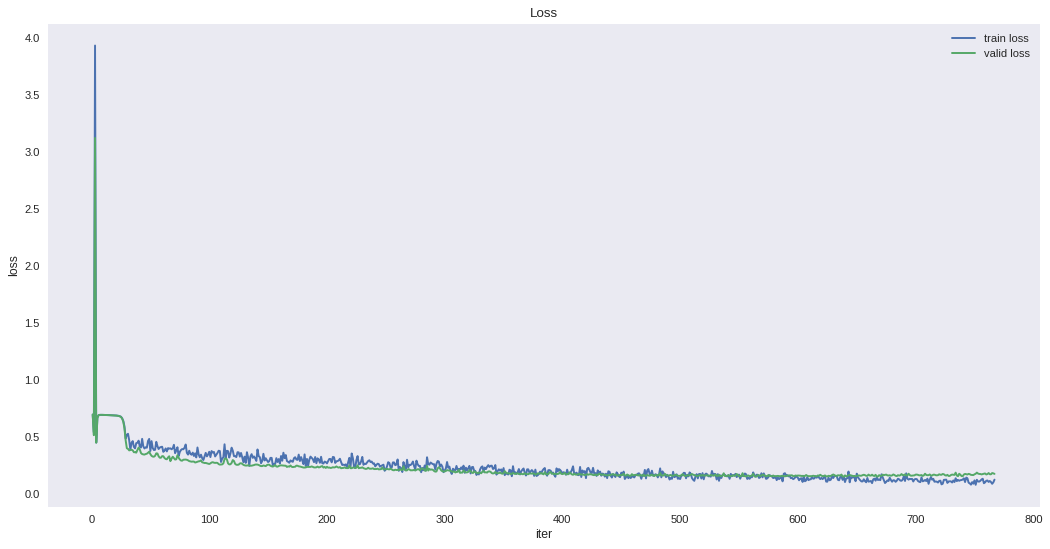

In [58]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
iterations = list(range(1,iteration+1))
plt.plot(iterations, train_loss, label = "train loss")
plt.plot(iterations, valid_loss, label = "valid loss")
plt.title("Loss")
plt.xlabel("iter")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()

# Visulalise sample prediction masks to help choosing the threshold to binirize

**Compute the predicted mask of the validation set**

In [59]:
with tf.Session() as sess:
  
    # restore the best model
    model_path = "./"+"my-model-"+str(best_iteration)
    saver.restore(sess, model_path)
    
    # compute the predicted mask of the validation set
    mask_predicted = sess.run(out, feed_dict=feed_dict_validation)

INFO:tensorflow:Restoring parameters from ./my-model-638


## Visualize some raw predicted mask 

In [0]:
def process_output_masks(masks, threshold = 0.5):
  
    masks_copy = masks.copy()
  
    # squeeze mask
    masks_squeezed = np.squeeze(masks_copy)
    
    # iterate throug each mask
    for n in range(masks_squeezed.shape[0]):
        # normalize mask            
        masks_squeezed[n] = (masks_squeezed[n] - masks_squeezed[n].min())/(masks_squeezed[n].max() - masks_squeezed[n].min())
#         masks_squeezed[n] *= 1.0/masks_squeezed[n].max() 
        # binirize mask
#         masks_squeezed[n] = np.where(masks_squeezed[n]<threshold, 0, 1)
        masks_squeezed[n] = np.where(masks_squeezed[n]>threshold, 1, 0)
        
    # return processed mask
    return masks_squeezed

In [0]:
mask_processed = process_output_masks(mask_predicted)

In [0]:
mask_validation_squeezed = np.squeeze(mask_validation)
mask_predicted_squeezed = np.squeeze(mask_predicted)

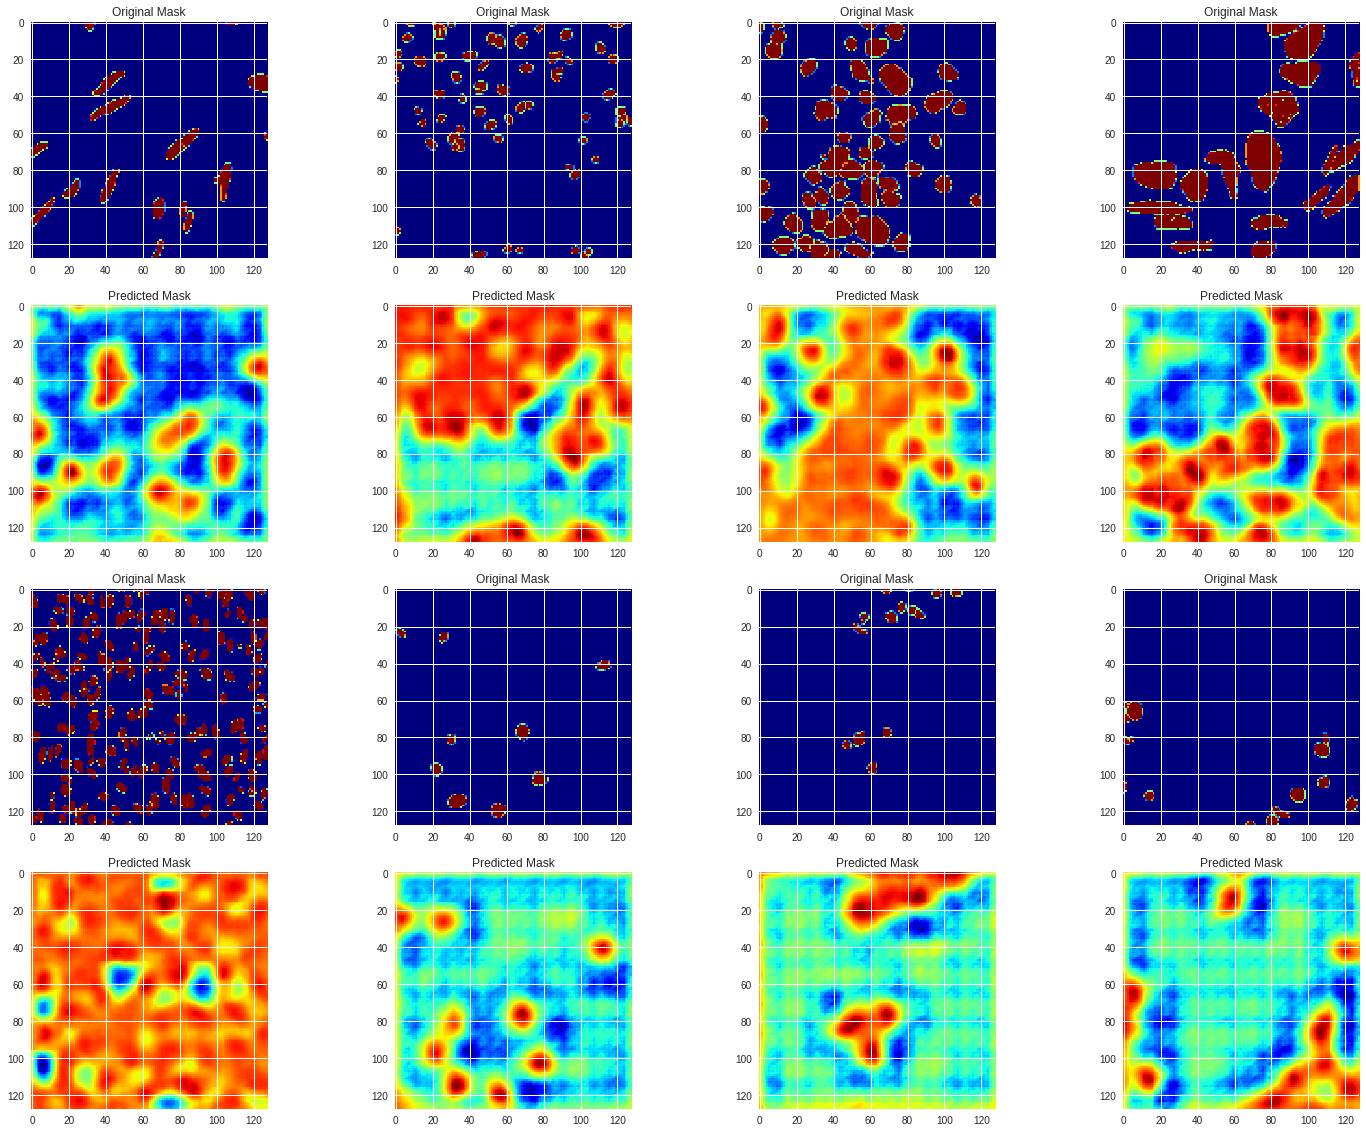

In [64]:
matplotlib.rcParams['figure.figsize'] = (25.0, 20.0)
plt.subplot(4,4,1)
plt.title("Original Mask")
plt.imshow(mask_validation_squeezed[0], cmap='jet')
plt.subplot(4,4,1+4)
plt.title("Predicted Mask")
plt.imshow(mask_predicted_squeezed[0],cmap='jet')
plt.subplot(4,4,2)
plt.title("Original Mask")
plt.imshow(mask_validation_squeezed[1],cmap='jet')
plt.subplot(4,4,2+4)
plt.title("Predicted Mask")
plt.imshow(mask_predicted_squeezed[1], cmap='jet')
plt.subplot(4,4,3)
plt.title("Original Mask")
plt.imshow(mask_validation_squeezed[2], cmap='jet')
plt.subplot(4,4,3+4)
plt.title("Predicted Mask")
plt.imshow(mask_predicted_squeezed[2], cmap='jet')
plt.subplot(4,4,4)
plt.title("Original Mask")
plt.imshow(mask_validation_squeezed[3], cmap='jet')
plt.subplot(4,4,4+4)
plt.title("Predicted Mask")
plt.imshow(mask_predicted_squeezed[3], cmap='jet')
plt.subplot(4,4,9)
plt.title("Original Mask")
plt.imshow(mask_validation_squeezed[4], cmap='jet')
plt.subplot(4,4,1+12)
plt.title("Predicted Mask")
plt.imshow(mask_predicted_squeezed[4], cmap='jet')
plt.subplot(4,4,10)
plt.title("Original Mask")
plt.imshow(mask_validation_squeezed[5], cmap='jet')
plt.subplot(4,4,2+12)
plt.title("Predicted Mask")
plt.imshow(mask_predicted_squeezed[5], cmap='jet')
plt.subplot(4,4,11)
plt.title("Original Mask")
plt.imshow(mask_validation_squeezed[6], cmap='jet')
plt.subplot(4,4,3+12)
plt.title("Predicted Mask")
plt.imshow(mask_predicted_squeezed[6], cmap='jet')
plt.subplot(4,4,12)
plt.title("Original Mask")
plt.imshow(mask_validation_squeezed[7], cmap='jet')
plt.subplot(4,4,4+12)
plt.title("Predicted Mask")
plt.imshow(mask_predicted_squeezed[7],cmap='jet')
plt.show()

## Visualize some processed predicted mask with different thresholds

**A function to normalize and binirize a batch of mask**

**A function to plot some sample images and predicted masks by passing a threshold**

In [0]:
def plot_true_predicted_mask(mask_true, mask_predicted, threshold, index):
  
    mask_true_squeezed = np.squeeze(mask_true)
    mask_predicted = process_output_masks(mask_predicted, threshold)  
    
    matplotlib.rcParams['figure.figsize'] = (25.0, 20.0)
    plt.subplot(4,4,1)
    plt.title("Original Mask")
    plt.imshow(mask_true_squeezed[index[0]], cmap='jet')
    plt.subplot(4,4,1+4)
    plt.title("Processed Predicted Mask")
    plt.imshow(mask_predicted[index[0]], cmap='jet')
    plt.subplot(4,4,2)
    plt.title("Original Mask")
    plt.imshow(mask_true_squeezed[index[1]], cmap='jet')
    plt.subplot(4,4,2+4)
    plt.title("Processed Predicted Mask")
    plt.imshow(mask_predicted[index[1]], cmap='jet')
    plt.subplot(4,4,3)
    plt.title("Original Mask")
    plt.imshow(mask_true_squeezed[index[2]], cmap='jet')
    plt.subplot(4,4,3+4)
    plt.title("Processed Predicted Mask")
    plt.imshow(mask_predicted[index[2]], cmap='jet')
    plt.subplot(4,4,4)
    plt.title("Original Mask")
    plt.imshow(mask_true_squeezed[index[3]], cmap='jet')
    plt.subplot(4,4,4+4)
    plt.title("Processed Predicted Mask")
    plt.imshow(mask_predicted[index[3]], cmap='jet')
    plt.subplot(4,4,9)
    plt.title("Original Mask")
    plt.imshow(mask_true_squeezed[index[4]], cmap='jet')
    plt.subplot(4,4,1+12)
    plt.title("Processed Predicted Mask")
    plt.imshow(mask_predicted[index[4]], cmap='jet')
    plt.subplot(4,4,10)
    plt.title("Original Mask")
    plt.imshow(mask_true_squeezed[index[5]], cmap='jet')
    plt.subplot(4,4,2+12)
    plt.title("Processed Predicted Mask")
    plt.imshow(mask_predicted[index[5]], cmap='jet')
    plt.subplot(4,4,11)
    plt.title("Original Mask")
    plt.imshow(mask_true_squeezed[index[6]], cmap='jet')
    plt.subplot(4,4,3+12)
    plt.title("Processed Predicted Mask")
    plt.imshow(mask_predicted[index[6]], cmap='jet')
    plt.subplot(4,4,12)
    plt.title("Original Mask")
    plt.imshow(mask_true_squeezed[index[7]], cmap='jet')
    plt.subplot(4,4,4+12)
    plt.title("Processed Predicted Mask")
    plt.imshow(mask_predicted[index[7]], cmap='jet')
    plt.show()

In [0]:
index = np.random.choice(range(mask_validation.shape[0]), size=16)

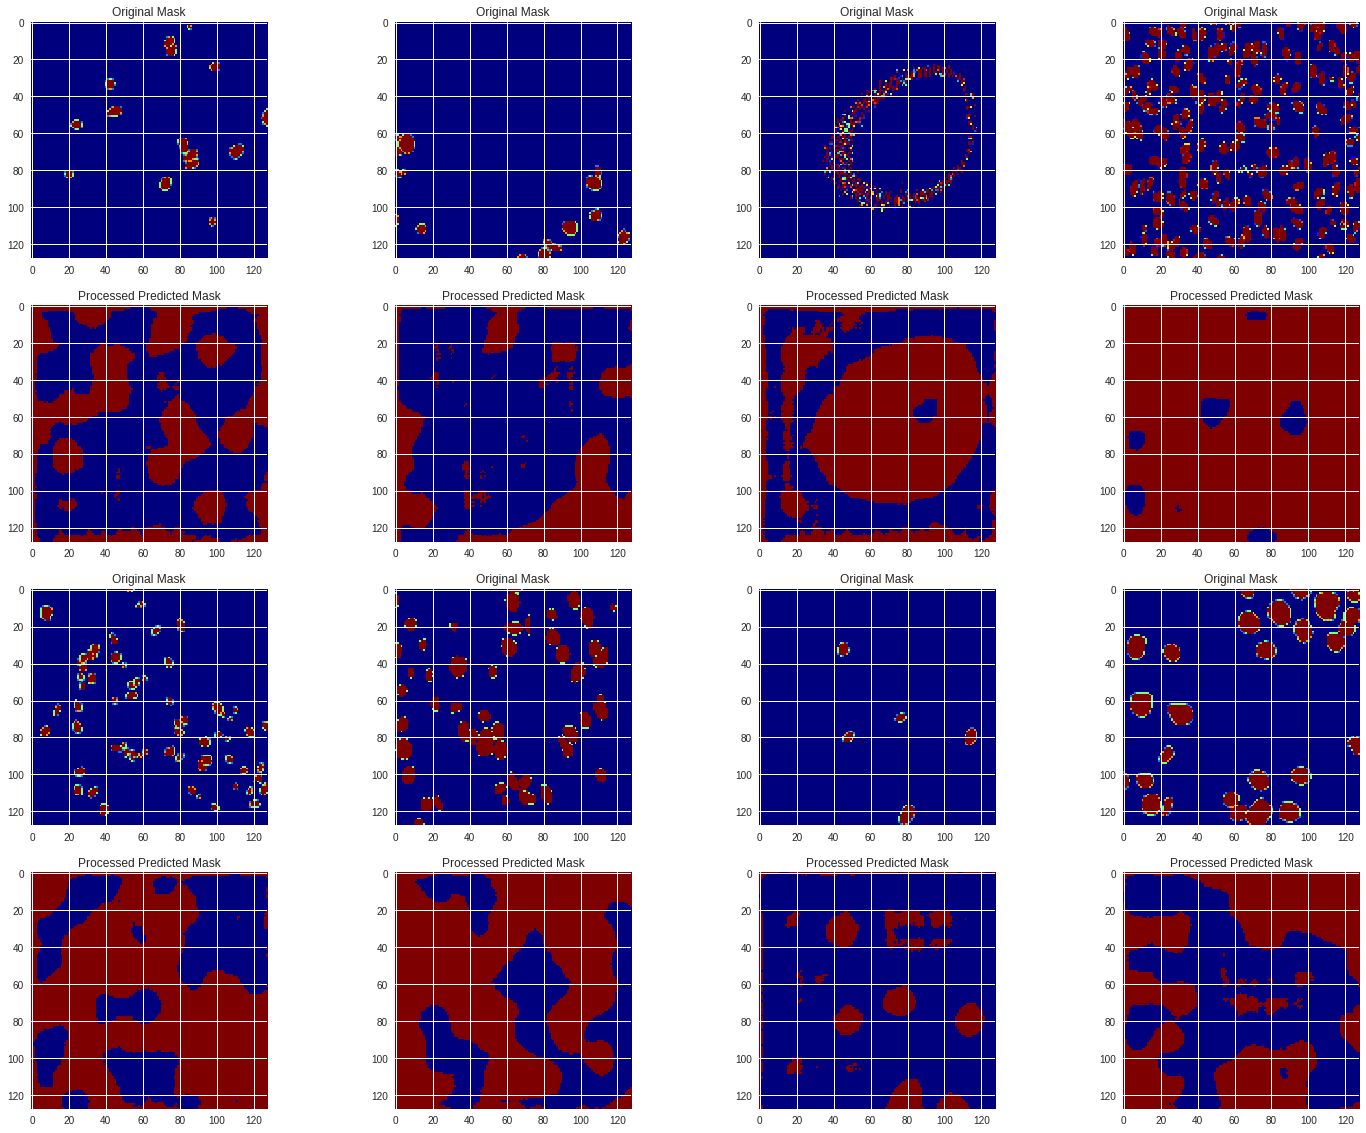

In [68]:
plot_true_predicted_mask(mask_validation, mask_predicted, 0.5, index)

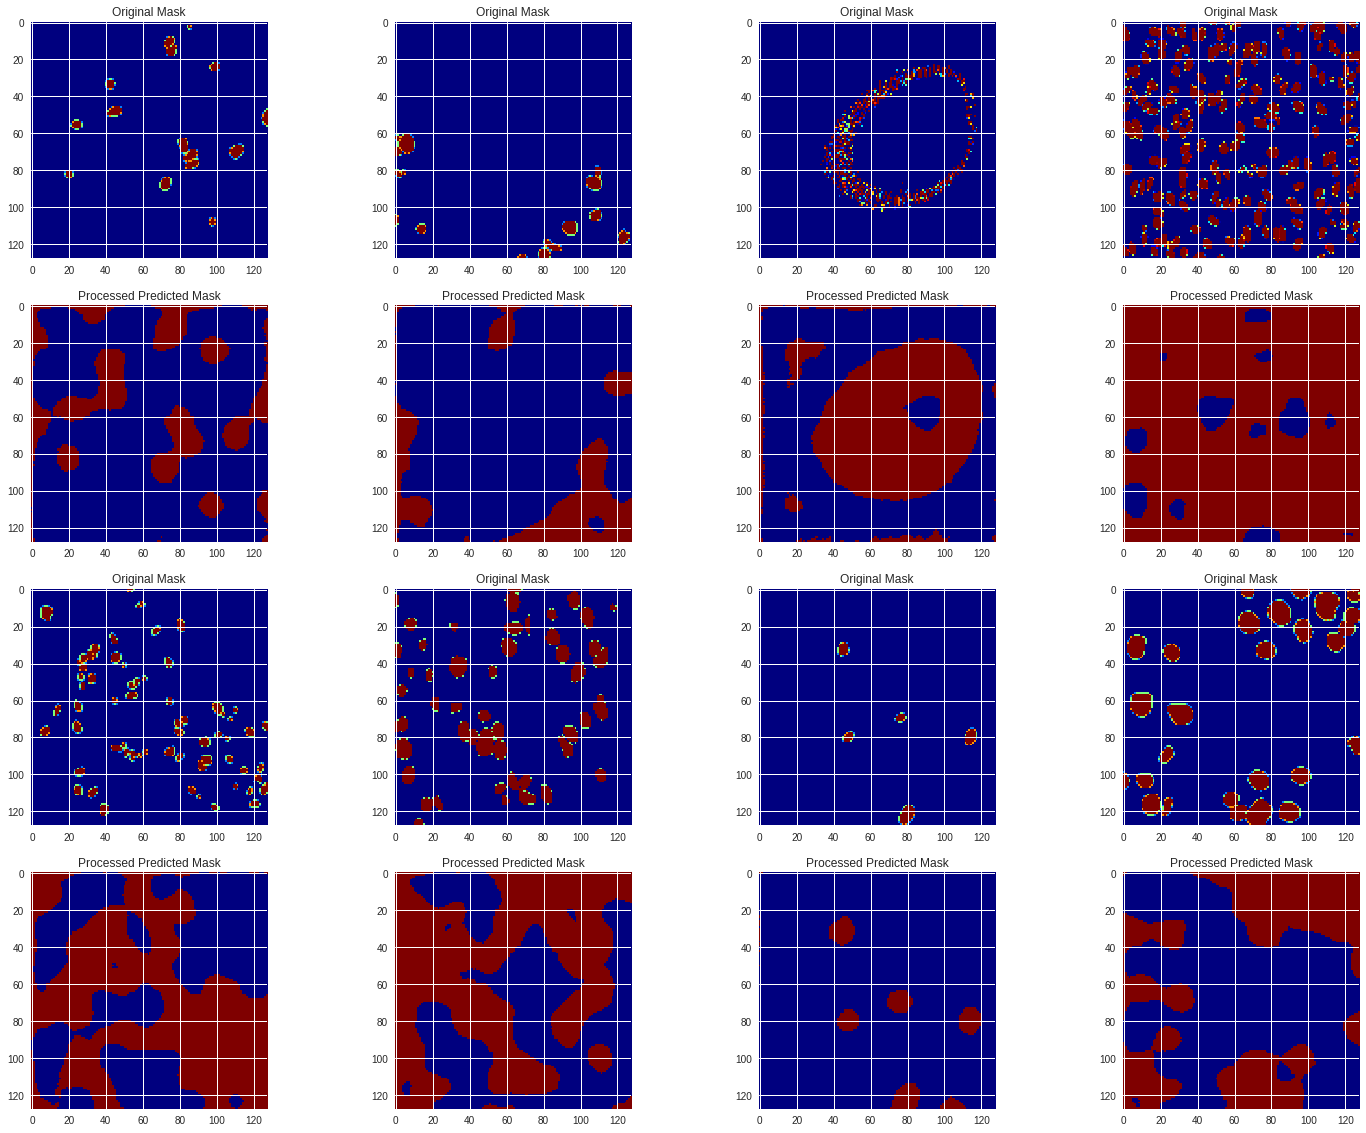

In [69]:
plot_true_predicted_mask(mask_validation, mask_predicted, 0.6, index)

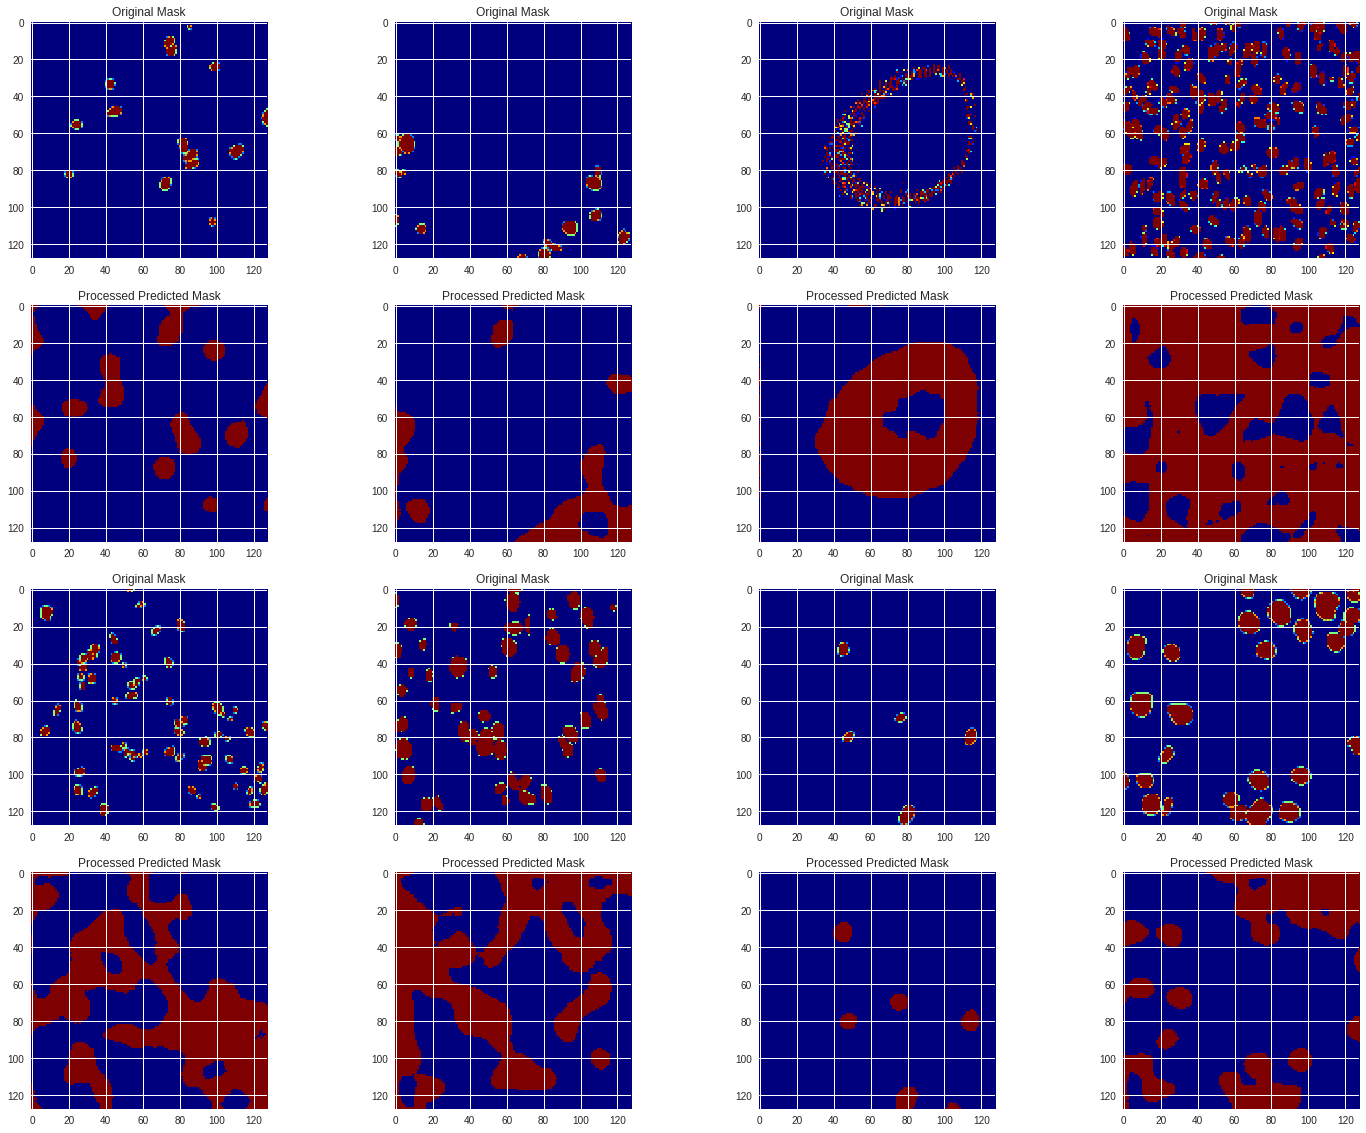

In [70]:
plot_true_predicted_mask(mask_validation, mask_predicted, 0.7, index)

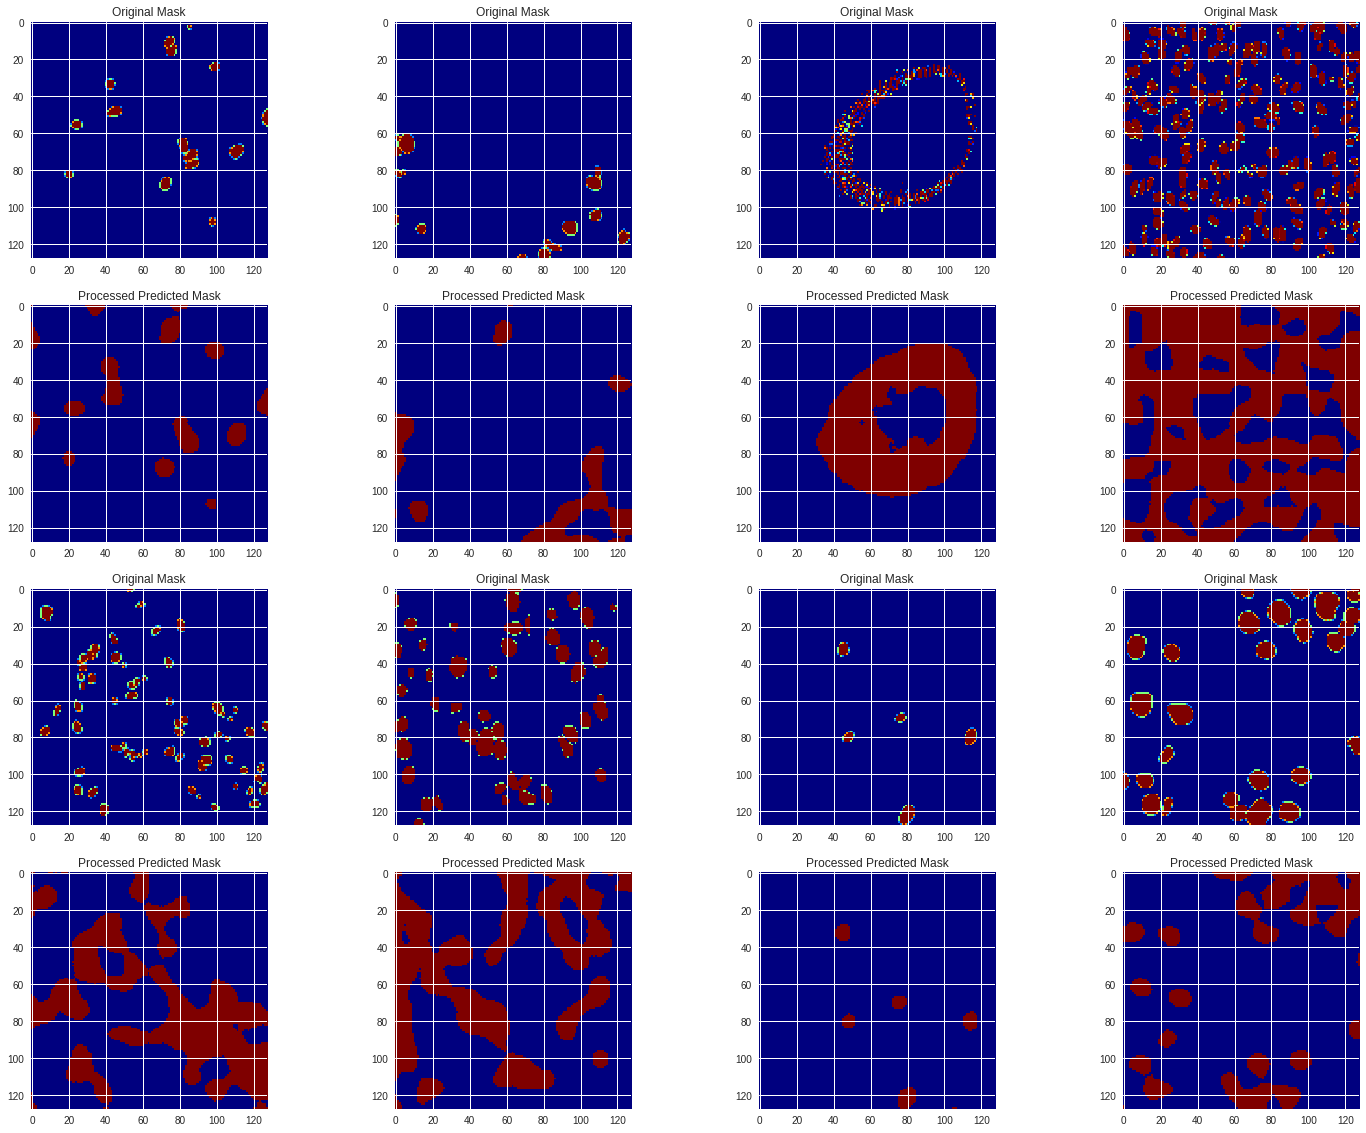

In [71]:
plot_true_predicted_mask(mask_validation, mask_predicted, 0.75, index)

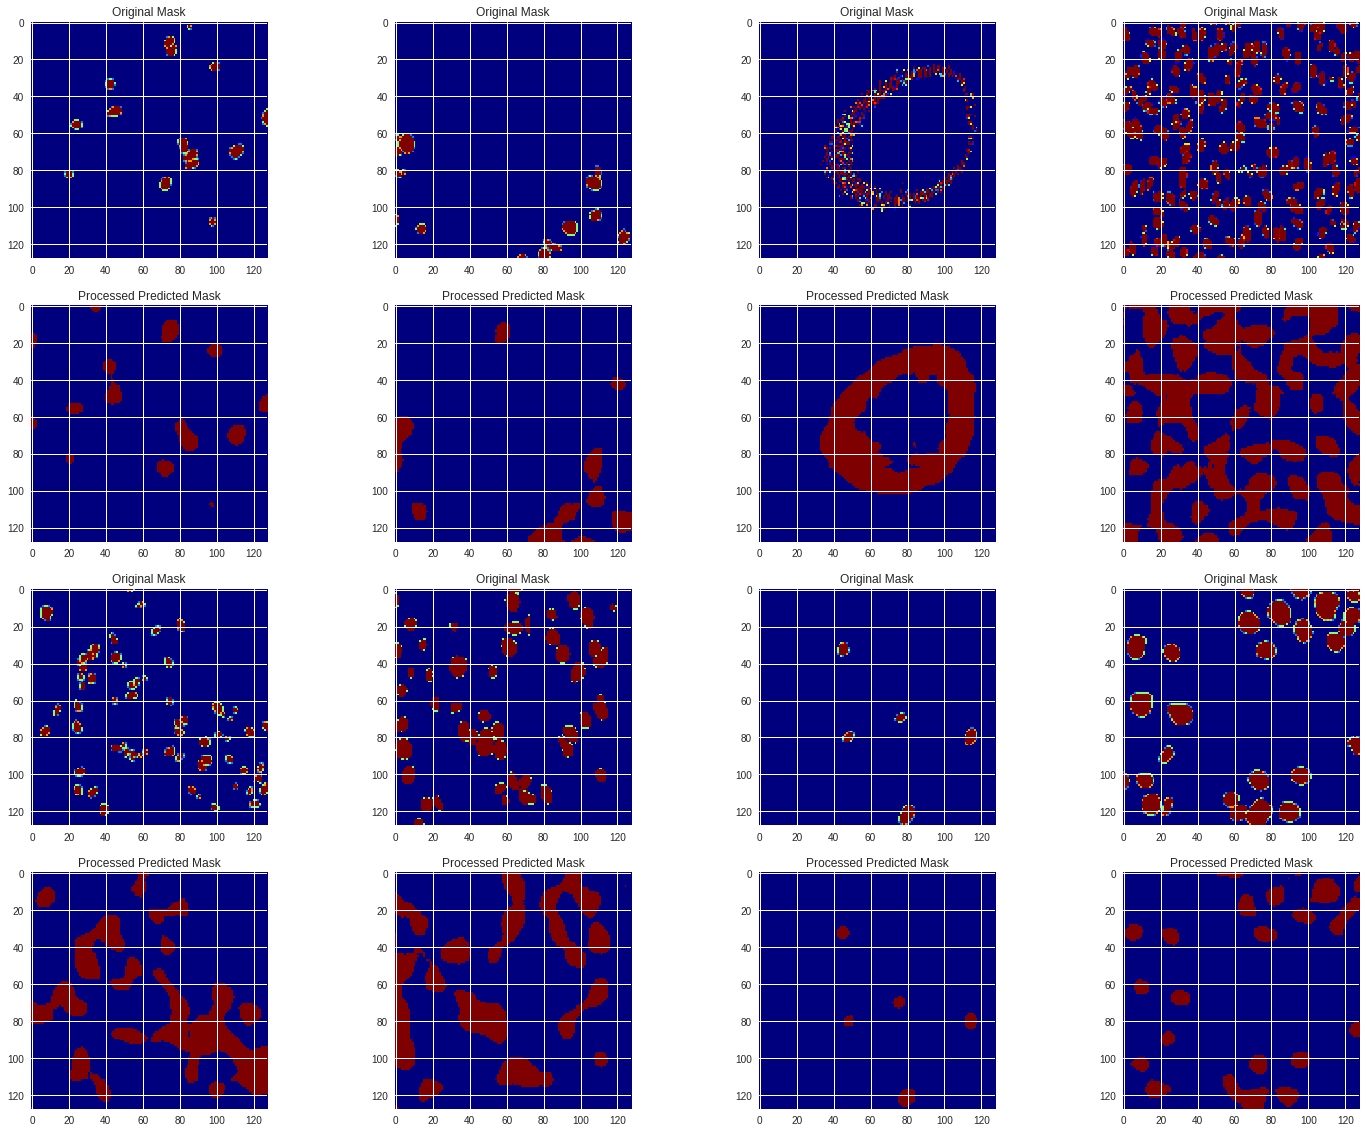

In [72]:
plot_true_predicted_mask(mask_validation, mask_predicted, 0.80, index)

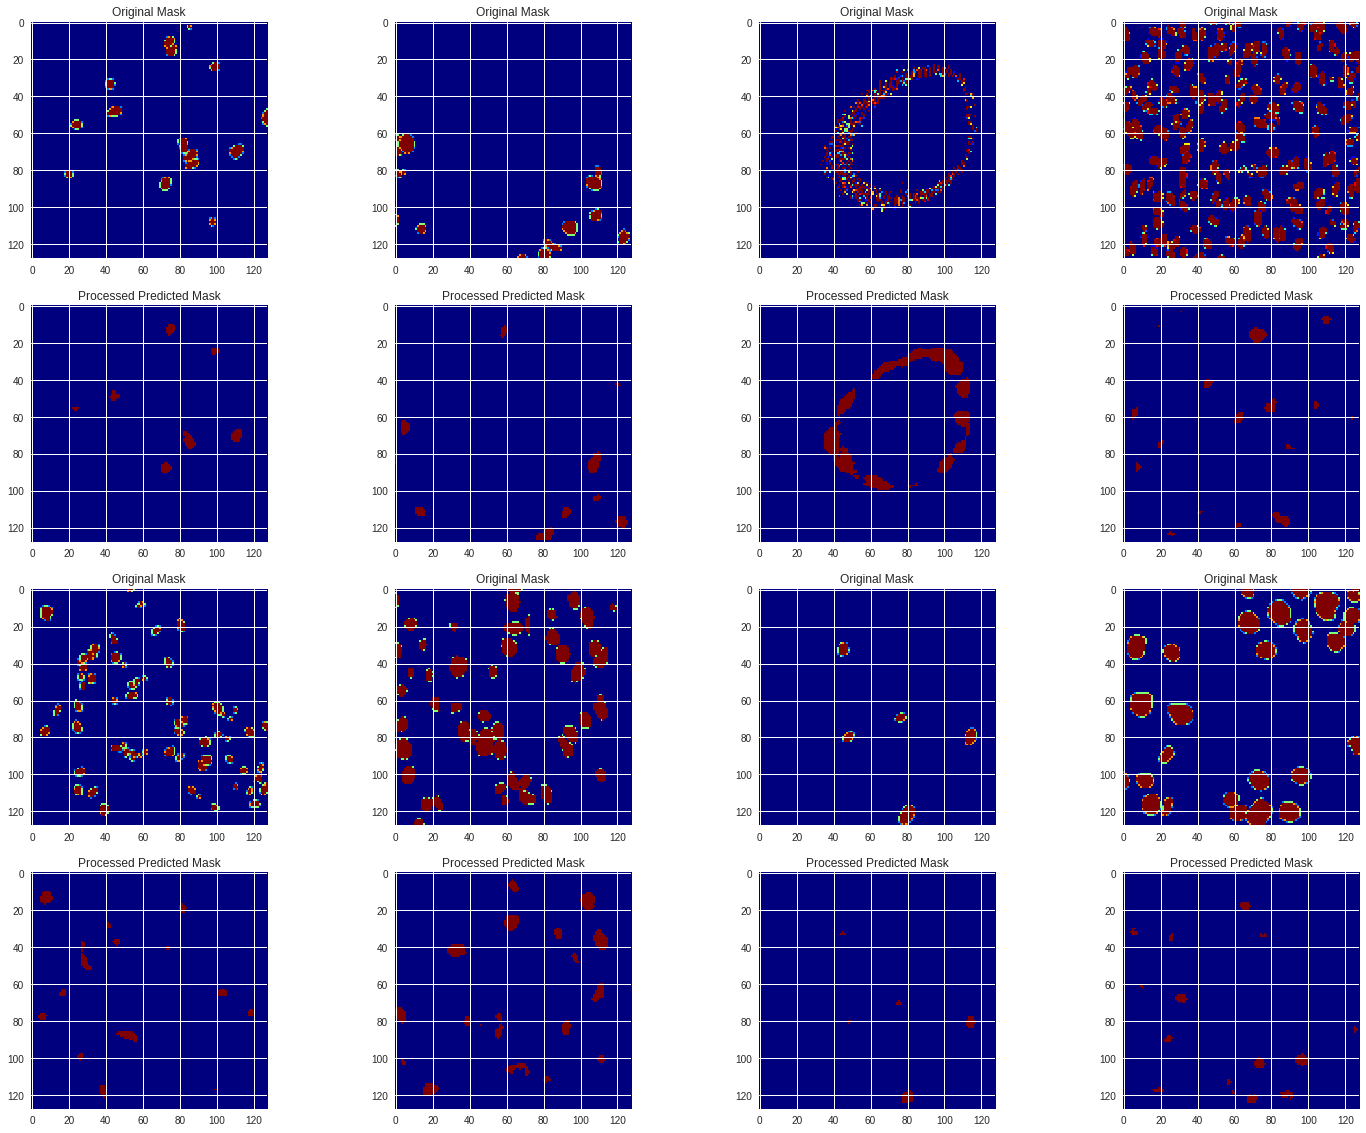

In [73]:
plot_true_predicted_mask(mask_validation, mask_predicted, 0.90, index)

# Compute prediction and save submission file

In [74]:
with tf.Session() as sess:
  
    # restore the best model
    model_path = "./"+"my-model-"+str(best_iteration)
    saver.restore(sess, model_path)
    
    n = len(test_ids)
    k = 10
    step = n//k
    
    # array to store the prediction
    preds = np.array([])
    
    EncodedPixels = []

    # iterate through each fold
    for i in range(k):

        # start and end indices of the fold
        if i != (k-1):
            start = (step*i)
            end = (step*(i+1)) 
        else:
            start = (step*i)
            end = len(test_ids)
        
        # create array of indices
        indices = list(range(start, end))
        indices = np.array(indices)
        
        # generate batch of test data
        image_test, shape_test = generate_batch(indices, test_set = True)
        
        # feed dict
        feed_dict_test =  {x: image_test, batchsize: indices.shape[0]}
        
        # compute predicted masks
        mask_predicted_test = sess.run(out, feed_dict=feed_dict_test)
        
        # encode predicted masks
        EncodedPixels = EncodedPixels + encode_masks(mask_predicted_test, shape_test, threshold = 0.80)
    
    # create a submission file
    submission_path = "./submission.csv"
    submission = pd.DataFrame({"ImageId":test_ids,"EncodedPixels": EncodedPixels}, columns=["ImageId","EncodedPixels" ])
    submission.to_csv(submission_path, header = True, index=False)

INFO:tensorflow:Restoring parameters from ./my-model-638


**Save the submission file in google drive**

In [0]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Create & upload a text file.
uploaded = drive.CreateFile({'title': 'submission.csv', 'parents':[{u'id': file_id_data["folder"]}]})
uploaded.SetContentFile("submission.csv")
uploaded.Upload()